In [1]:
import os, sys
import numpy
from collections import defaultdict, Counter
import datetime


In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/d/dev/git/miRExplore/python/nbs
['/mnt/d/dev/git/miRExplore/python', '/mnt/d/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [3]:
from textdb.PubmedDateDB import PubmedDateDB
from synonymes.mirnaID import miRNA, miRNAPART
from textdb.MiGenRelDB import MiGenRelDB

In [4]:
allDatesFile = "/mnt/d/dev/data/pmid_jun2020/aggregated_pmid/allpmids.date"
sentDB = PubmedDateDB.loadFromFile(allDatesFile)

Loading Dates
Loading Dates Finished


In [5]:
len(sentDB.docid2date)

31295217

In [6]:
sentDB.get_document("31378854")

(2019, 8, 2)

In [128]:
ym2pmids = defaultdict(set)
for x in sentDB.docid2date:
    ddate = list(sentDB.docid2date[x])
    
    if ddate[0] == 0:
        continue
        
    if ddate[1] == 0:
        ddate[1] = 1
    ddate[2] = 1
    
    try:
        ym2pmids[datetime.datetime.strptime("{}-{}-{}".format(*ddate), '%Y-%m-%d')].add(x)
    except:
        print(ddate)
        break

In [129]:
ym2counts = Counter()
for date in ym2pmids:
    ym2counts[date] += len(ym2pmids[date])

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()

def plotDateCounts(xdates, ydata, fname=None):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(figsize=(12,6))
    """
    xdatesTS = [datetime.datetime.timestamp(x) for x in xdates]
    allyears = sorted(set([int(x.year) for x in xdates]))
    
    minYearNum = min(allyears)
    maxYearNum = max(allyears)
    
    minYear = datetime.datetime.strptime("{}-1-1".format(minYearNum), '%Y-%m-%d')
    maxYear = datetime.datetime.strptime("{}-12-31".format(maxYearNum), '%Y-%m-%d')
    
    betweenTicks = []
    for i in range(minYear.year+1, maxYear.year+1):
        betweenTicks.append(
            datetime.datetime.strptime("{}-1-1".format(i), '%Y-%m-%d')
        )
        
    allticks = [minYear] + betweenTicks + [maxYear]
    """
    sns.scatterplot(x=xdates, y=ydata, ax=ax)
    

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    ax.set_xlim(min(xdates), max(xdates))
    #ax.set_xticks([datetime.datetime.timestamp(x) for x in allticks])
    #xticks = ax.get_xticks()
    #xticks_dates=[datetime.datetime.fromtimestamp(x).strftime('%Y-%m') for x in xticks]
    #ax.set_xticklabels(xticks_dates)
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    #ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)
    

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    #fig.autofmt_xdate()
    plt.xticks(rotation=90, ha="center")

    if fname != None:
        plt.savefig(fname)
    plt.show()

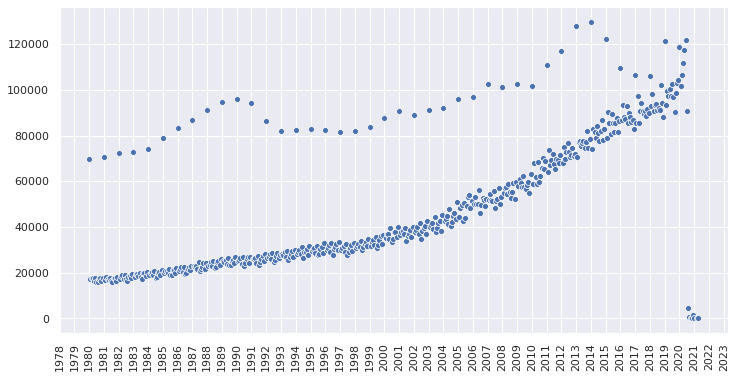

In [131]:
xdates = sorted([x for x in ym2counts])
xdates = [x for x in xdates if x.year >= 1980]
ydata = [ym2counts[x] for x in xdates]

plotDateCounts(xdates, ydata)

In [132]:
sum([ym2counts[x] for x in ym2counts])

29317804

In [15]:
from utils.tmutils import normalize_gene_names
normGeneSymbols = normalize_gene_names(path="/mnt/d/owncloud/data/miRExplore/obodir/" + "/hgnc_no_withdrawn.syn")

MAP3K7 TAB1


In [16]:
pmidBase ="/mnt/d/dev/data/pmid_jun2020/aggregated_pmid/"

print("Loading hsa")
mirelPMIDhsa = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMIDmmu = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)

relDBs = [mirelPMIDhsa, mirelPMIDmmu]

Loading hsa
Gene Symbols Normalized 77476
Loaded file /mnt/d/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.hsa.pmid
Accepted Doc IDs 40682
Rejected Doc IDs 0
Loading mmu
Gene Symbols Normalized 12366
Loaded file /mnt/d/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.mmu.pmid
Accepted Doc IDs 36942
Rejected Doc IDs 0


In [18]:
miRNAGenePMIDs = set()
for rdb in relDBs:
    for rpmid in rdb.get_evidence_docids():
        miRNAGenePMIDs.add(rpmid)

In [133]:
ym2InteractionCounts = Counter()
countsperYear = Counter()
totalPMIDs = 0
for date in ym2pmids:
    intersectPMIDs = len(miRNAGenePMIDs.intersection(ym2pmids[date]))
    ym2InteractionCounts[date] += intersectPMIDs
    totalPMIDs += intersectPMIDs
    countsperYear[date.year] += intersectPMIDs
    
print(totalPMIDs)

36037


In [134]:
sum([ym2InteractionCounts[x] for x in ym2InteractionCounts])

36037

In [135]:
for x in sorted(countsperYear):
    if x < 1980:
        continue
    
    print(x, countsperYear[x])

1980 0
1981 0
1982 0
1983 0
1984 0
1985 0
1986 0
1987 0
1988 0
1989 1
1990 1
1991 1
1992 1
1993 1
1994 0
1995 0
1996 1
1997 0
1998 0
1999 2
2000 1
2001 1
2002 1
2003 4
2004 9
2005 21
2006 42
2007 121
2008 285
2009 541
2010 856
2011 1270
2012 1723
2013 2375
2014 2940
2015 3903
2016 3945
2017 4699
2018 5255
2019 5509
2020 2528
2021 0


In [136]:
sDates = sorted([d for d in ym2InteractionCounts])

sDates[:5]+sDates[-5:]

[datetime.datetime(1781, 1, 1, 0, 0),
 datetime.datetime(1781, 2, 1, 0, 0),
 datetime.datetime(1781, 3, 1, 0, 0),
 datetime.datetime(1781, 4, 1, 0, 0),
 datetime.datetime(1781, 5, 1, 0, 0),
 datetime.datetime(2020, 11, 1, 0, 0),
 datetime.datetime(2020, 12, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 3, 1, 0, 0),
 datetime.datetime(2021, 4, 1, 0, 0)]

[datetime.datetime(2005, 1, 1, 0, 0), datetime.datetime(2005, 2, 1, 0, 0), datetime.datetime(2005, 3, 1, 0, 0), datetime.datetime(2005, 4, 1, 0, 0), datetime.datetime(2005, 5, 1, 0, 0), datetime.datetime(2020, 8, 1, 0, 0), datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2020, 10, 1, 0, 0), datetime.datetime(2020, 11, 1, 0, 0), datetime.datetime(2020, 12, 1, 0, 0)]


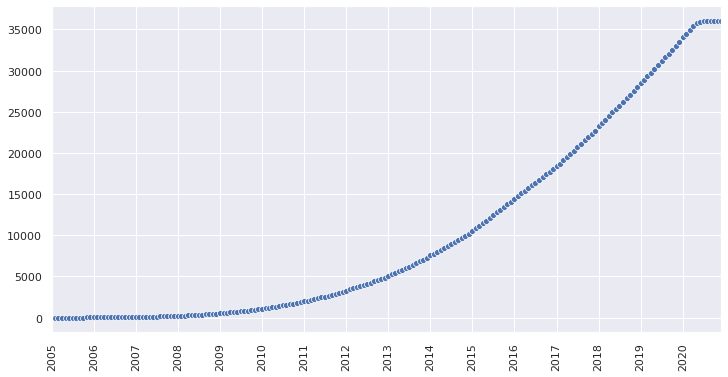

In [139]:
xdates = sorted([x for x in ym2InteractionCounts])
xdates = [x for x in xdates if x.year >= 2005 and x.year < 2021]
ydata = [ym2InteractionCounts[x] for x in xdates]

ycumdata = [ydata[0]]
for i in range(1, len(ydata)):
    cumCount = ycumdata[-1] + ydata[i]
    ycumdata.append(cumCount)

print(xdates[:5]+xdates[-5:])
plotDateCounts(xdates, ycumdata, "pubmed_mirna_gene.png")


In [140]:
len(ycumdata)

192